In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

In [2]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [3]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [4]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [25]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [26]:
num_particles = 1000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [27]:
tidp = install_tidp(line, block_mvt=29e-3)
tw = line.twiss4d()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [28]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2809114751256145


In [29]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


In [30]:
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

means = []
std_pos = []
std_neg = []
hist = {}
line.scattering.enable()
for turn in range(num_turns):
    if turn % 100 == 0:
        print(f"Turn {turn}/{num_turns}")
    means.append(np.mean(part.x[part.state > 0]))
    std_pos.append(np.std(part.x[(part.x>=0) & (part.state > 0)]))
    std_neg.append(np.std(part.x[(part.x<0)  & (part.state > 0)]))
    hist[turn] = part.x[part.state > 0]
    line.track(particles=part, num_turns=1, time=False)

line.scattering.disable()

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.
Turn 0/6000
Turn 100/6000
Turn 200/6000
Turn 300/6000
Turn 400/6000
Turn 500/6000
Turn 600/6000
Turn 700/6000
Turn 800/6000
Turn 900/6000
Turn 1000/6000
Turn 1100/6000
Turn 1200/6000
Turn 1300/6000
Turn 1400/6000
Turn 1500/6000
Turn 1600/6000
Turn 1700/6000
Turn 1800/6000
Turn 1900/6000
Turn 2000/6000
Turn 2100/6000
Turn 2200/6000
Turn 2300/6000
Turn 2400/6000
Turn 2500/6000
Turn 2600/6000
Turn 2700/6000
Turn 2800/6000
Turn 2900/6000


/Users/lisepauwels/miniforge3/envs/xcoll/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lisepauwels/miniforge3/envs/xcoll/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/lisepauwels/miniforge3/envs/xcoll/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Turn 3000/6000
Turn 3100/6000
Turn 3200/6000
Turn 3300/6000
Turn 3400/6000
Turn 3500/6000
Turn 3600/6000
Turn 3700/6000
Turn 3800/6000
Turn 3900/6000
Turn 4000/6000
Turn 4100/6000
Turn 4200/6000
Turn 4300/6000
Turn 4400/6000
Turn 4500/6000
Turn 4600/6000
Turn 4700/6000
Turn 4800/6000
Turn 4900/6000
Turn 5000/6000
Turn 5100/6000
Turn 5200/6000
Turn 5300/6000
Turn 5400/6000
Turn 5500/6000
Turn 5600/6000
Turn 5700/6000
Turn 5800/6000
Turn 5900/6000


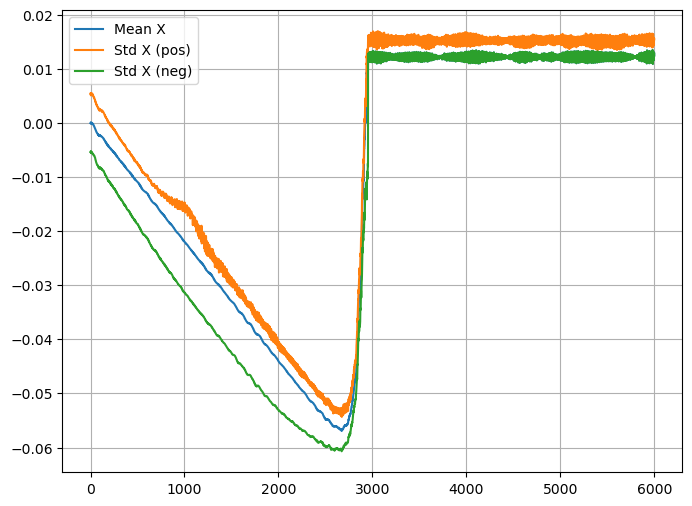

In [ ]:
means= np.array(means)
std_pos = np.array(std_pos)
std_neg = np.array(std_neg) 

fig, ax = plt.subplots(1,1, figsize=(8,6))

turns = np.linspace(0, num_turns-1, num_turns)

ax.plot(turns, means, label='Mean X')
ax.plot(turns, means + std_pos, label='Std X (pos)')
ax.plot(turns, means - std_neg, label='Std X (neg)')
ax.legend()
ax.grid()
# plt.savefig('20251110/mean_std_x.png', dpi=300)

In [32]:
np.unique(part.state, return_counts=True)

(array([0, 1]), array([998,   2]))

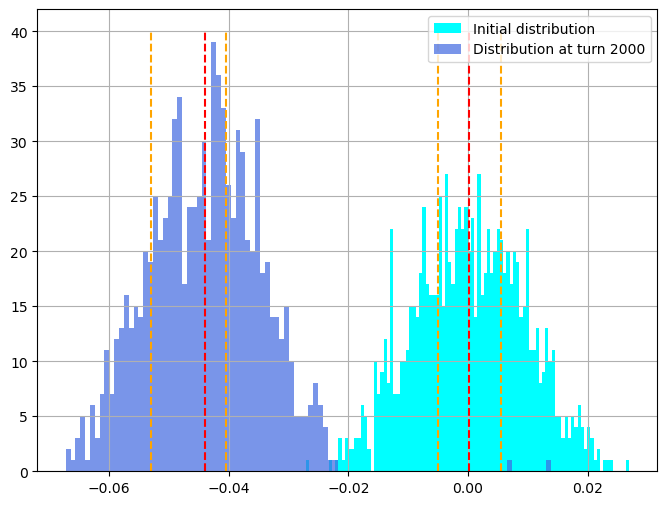

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.hist(hist[0], bins=100, color='cyan', label='Initial distribution')
ax.hist(hist[2000], bins=100, color='royalblue', alpha=0.7, label='Distribution at turn 2000')
ax.vlines(np.mean(hist[0]), ymin=0, ymax=40, colors='r', linestyles='dashed')
ax.vlines(np.mean(hist[2000]), ymin=0, ymax=40, colors='r', linestyles='dashed')
ax.vlines(means[0] + std_pos[0], ymin=0, ymax=40, colors='orange', linestyles='dashed')
ax.vlines(means[0] - std_neg[0], ymin=0, ymax=40, colors='orange', linestyles='dashed')
ax.vlines(means[2000] + std_pos[2000], ymin=0, ymax=40, colors='orange', linestyles='dashed')
ax.vlines(means[2000] - std_neg[2000], ymin=0, ymax=40, colors='orange', linestyles='dashed')
ax.legend()

In [54]:
abs(np.max(hist[2000]) - np.min(hist[2000]))

np.float64(0.08108461015006896)

In [55]:
abs(np.max(hist[0]) - np.min(hist[0]))

np.float64(0.05400711558752948)

In [61]:
print(np.max(hist[0]) - np.mean(hist[0]))
print(np.max(hist[2000]) - np.mean(hist[2000]))

0.026701986417047848
0.057778010990250074


In [65]:
print(np.abs(np.min(hist[0])) - np.abs(np.mean(hist[0])))
print(np.abs(np.min(hist[2000])) - np.abs(np.mean(hist[2000])))

0.02686554227794279
0.023306599159818878


Bunch seems to become bigger and more on the negative side